<a href="https://colab.research.google.com/github/pharringtonp19/mecon/blob/main/notebooks/Income_Expansion_Path.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import jax 
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial 

In [2]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

### **Economic Functions**

In [18]:
def utility_fn(scale, alpha, x1, x2): 
  return scale *x1**alpha * x2 **(1-alpha)

def budget_constraint(m, p1, p2, x1):
  return m/p2 - p1/p2*x1

def expenditure_fn(p1, p2, x1, x2):
  return p1*x1 + p2*x2

### **Solver-Related Functions**

In [19]:
def F(utility_fn, expenditure_fn, income, params):
  x1, x2, l = params
  
  a1, a2 = jax.grad(utility_fn, argnums=(0, 1))(x1, x2)
  b1, b2 = jax.grad(expenditure_fn, argnums=(0, 1))(x1, x2)

  return jnp.array([a1 - l*b1, a2-l*b2, income - expenditure_fn(x1, x2)])

def solver(f_root):

  g = lambda z: z - jnp.linalg.solve(jax.jacobian(f_root)(z), f_root(z))

  def body_fn(val):
    next_guess = g(val)
    return next_guess #jnp.array(jnp.maximum(next_guess[:-1], jnp.zeros(2)), next_guess[-1])

  def cond_fn(val):
    return jnp.linalg.norm(f_root(val)) > 1e-3

  z = jax.lax.while_loop(cond_fn, body_fn, init_val=jnp.ones(3))
  return z 

def optimal_bundle(scale, alpha, income, p1, p2):
  partial_utility_fn = partial(utility_fn, scale, alpha)
  partial_expenditure_fn = partial(expenditure_fn, p1, p2)
  f_root = partial(F, partial_utility_fn, partial_expenditure_fn, income)
  opt_bundle = solver(f_root)
  x1_opt, x2_opt = opt_bundle[0], opt_bundle[1]
  return x1_opt, x2_opt

### **Optimal Bundle**

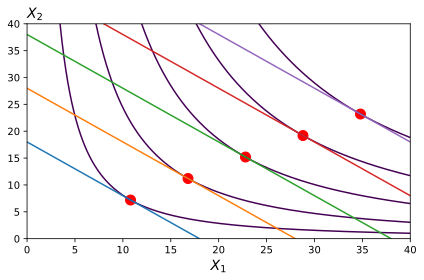

In [33]:
scale = 2.
alpha = 0.6 
income = 40.0  
p1, p2 = 5., 5. 

x_end = 40.


xp=jnp.linspace(0., x_end,200)  # N
yp=jnp.linspace(0.,x_end,200)  # M

X, Y = jnp.meshgrid(xp, yp)
def func(x,y):
  return partial(utility_fn, scale, alpha)(x,y)
Z = func(X,Y)

fig = plt.figure(dpi=300, tight_layout=True)

for i in range(5):
  income += 50.0 
  x1_opt, x2_opt = optimal_bundle(scale, alpha, income, p1, p2)
  u_opt = utility_fn(scale, alpha, x1_opt, x2_opt)
  hs = jnp.linspace(0, x_end)
  plt.contour(xp,yp,Z,levels=[u_opt.item()]) 
  cs = jax.vmap(partial(budget_constraint, income, p1, p2))(hs)
  plt.plot(hs,cs, label='budget line')
  plt.scatter(x1_opt, x2_opt, color='red', s=100, label='Optimal Bundle')
plt.ylim(0, x_end)
plt.xlim(0, x_end)
plt.xlabel(r'$X_1$', size=14)
plt.title(r'$X_2$', size=14, loc='left')
fig.savefig('iep.png', format='png')
plt.show()

In [41]:
incomes = jnp.linspace(5., 350., 100)
x1_opt, x2_opt = jax.vmap(optimal_bundle, in_axes=(None, None, 0, None, None))(scale, alpha, incomes, p1, p1)

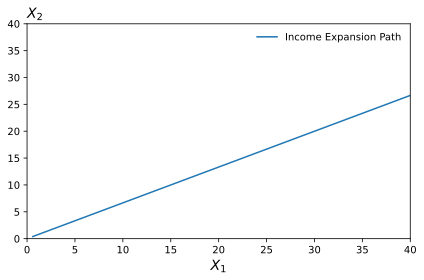

In [45]:
fig = plt.figure(dpi=300, tight_layout=True)
plt.plot(x1_opt, x2_opt, label='Income Expansion Path')
plt.ylim(0, x_end)
plt.xlim(0, x_end)
plt.xlabel(r'$X_1$', size=14)
plt.title(r'$X_2$', size=14, loc='left')
plt.legend(frameon=False)
fig.savefig('iep_plain.png', format='png')
plt.show()